### importing libraries

In [1]:
from tensorflow.keras import layers, models, datasets, Model
from PIL import Image

2025-07-31 03:21:04.072667: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 03:21:04.279747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 03:21:04.371084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753942864.524829    2090 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753942864.560867    2090 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753942864.809202    2090 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### loading data

In [2]:
# EXEMPLO AQUI: É NESSE FORMATO QUE PRECISAMOS


(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Setting input shape, normalizing color channel, setting datatype to float32 for numerical stability
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

classes = [str(i) for i in range(10)]

 3252224/11490434 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step

KeyboardInterrupt: 

### Data preprocessing 

#### Image size reduction
2.5 x reduction --> 6.25 pixel number reduction

In [3]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration ---
SOURCE_DIR = './data/train/'      # Folder with class subfolders (e.g., A, B, C...)
OUTPUT_DIR = './data/resized/'    # Where to save the resized images
NEW_SIZE = (40, 30)               # New size for the images (width, height)

# --- 1. Function to resize and save a single image ---
def resize_and_save(relative_path):
    """
    Reads an image from its relative path, resizes it, and saves it to the
    output directory while maintaining the subfolder structure.
    """
    try:
        # Construct the full input and output paths
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)

        # Create the destination subdirectory if it doesn't exist
        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)

        # Read the image
        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            # print(f"Warning: Could not read {full_input_path}, skipping.")
            return 0 # Return 0 for failure

        # Resize the image using INTER_AREA for best downscaling results
        resized_image = cv2.resize(image, NEW_SIZE, interpolation=cv2.INTER_AREA)

        # Save the resized image
        cv2.imwrite(full_output_path, resized_image)
        return 1 # Return 1 for success
    except Exception as e:
        print(f"Error processing {relative_path}: {e}")
        return 0

# --- 2. Main execution block to run the process in parallel ---
if __name__ == "__main__":
    # Find all image files in the source directory and its subdirectories
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Get the path reomlative to the source directory (e.g., "A/image1.png")
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)
    
    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}. Please check the path.")
    else:
        print(f"Found {len(all_image_paths)} images to resize. Starting process...")

        # Use ProcessPoolExecutor to run resizing on all available CPU cores
        with ProcessPoolExecutor() as executor:
            # Use tqdm to create a progress bar
            results = list(tqdm(executor.map(resize_and_save, all_image_paths), total=len(all_image_paths)))

        total_processed = sum(results)
        print(f"\n✅ Done! Successfully resized and saved {total_processed} images to {OUTPUT_DIR}")

Found 24850 images to resize. Starting process...


100%|██████████| 24850/24850 [00:10<00:00, 2463.28it/s]



✅ Done! Successfully resized and saved 24850 images to ./data/resized/


#### Thresholding

##### OTSU

In [4]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration ---
# Use the resized images as the source for maximum efficiency
SOURCE_DIR = './data/resized/'
OUTPUT_DIR = './data/thresholded/'

# --- 1. Function to threshold and save a single image ---
def threshold_and_save(relative_path):
    """
    Reads an image, applies Otsu's thresholding, and saves the result.
    """
    try:
        # Construct full input and output paths
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)

        # Create the destination subdirectory if it doesn't exist
        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)

        # Read the image in grayscale
        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return 0  # Return 0 for failure

        # Apply Otsu's thresholding
        # The [1] selects the image array from the tuple returned by cv2.threshold
        thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Save the thresholded image
        cv2.imwrite(full_output_path, thresholded_image)
        return 1  # Return 1 for success
    except Exception as e:
        print(f"Error processing {relative_path}: {e}")
        return 0

# --- 2. Main execution block to run the process in parallel ---
if __name__ == "__main__":
    # Find all image files in the source directory
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)

    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}. Please check the path.")
    else:
        print(f"Found {len(all_image_paths)} images to threshold. Starting process...")

        # Use ProcessPoolExecutor to run on all available CPU cores
        with ProcessPoolExecutor() as executor:
            # Use tqdm to create a progress bar
            results = list(tqdm(executor.map(threshold_and_save, all_image_paths), total=len(all_image_paths)))

        total_processed = sum(results)
        print(f"\n✅ Done! Successfully processed and saved {total_processed} images to {OUTPUT_DIR}")

Found 24850 images to threshold. Starting process...


100%|██████████| 24850/24850 [00:09<00:00, 2718.32it/s]



✅ Done! Successfully processed and saved 24850 images to ./data/thresholded/


##### Adaptive Thresholding

In [5]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration ---
SOURCE_DIR = './data/resized/'
OUTPUT_DIR = './data/adaptive_thresholded/'
BLOCK_SIZE = 15  # Must be an odd number (e.g., 11, 15, 21)
C_CONSTANT = 4   # Constant to subtract from the mean (fine-tune this)

# --- 1. Function to apply adaptive thresholding and save ---
def adaptive_threshold_and_save(relative_path):
    """
    Reads an image, applies adaptive thresholding, and saves the result.
    """
    try:
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)

        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)

        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return 0

        # Apply Adaptive Thresholding
        thresholded_image = cv2.adaptiveThreshold(
            image,
            255,                                  # Max value to assign
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,       # Method to calculate threshold
            cv2.THRESH_BINARY_INV,                # Invert the image (character is white)
            BLOCK_SIZE,                           # Neighborhood size
            C_CONSTANT                            # Constant to subtract
        )

        cv2.imwrite(full_output_path, thresholded_image)
        return 1
    except Exception as e:
        print(f"Error processing {relative_path}: {e}")
        return 0

# --- 2. Main execution block ---
if __name__ == "__main__":
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)

    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}. Please check the path.")
    else:
        print(f"Found {len(all_image_paths)} images to process. Starting...")

        with ProcessPoolExecutor() as executor:
            results = list(tqdm(executor.map(adaptive_threshold_and_save, all_image_paths), total=len(all_image_paths)))

        total_processed = sum(results)
        print(f"\n✅ Done! Processed {total_processed} images saved to {OUTPUT_DIR}")

Found 24850 images to process. Starting...


100%|██████████| 24850/24850 [00:08<00:00, 2840.81it/s]



✅ Done! Processed 24850 images saved to ./data/adaptive_thresholded/


#### Data cleaning
Removing bad examples from the training dataset

In [6]:
import os
import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration: TUNE THESE VALUES ---
SOURCE_DIR = './data/thresholded/'
OUTPUT_DIR = './data/cleaned/'

# -- Contour Filters --
MIN_CONTOURS = 1      # Minimum number of contours to be considered valid
MAX_CONTOURS = 3     # Maximum number of contours (to filter out noisy images)

# This filters out images that are mostly blank or mostly solid white
MIN_AREA_RATIO = 0.20 
MAX_AREA_RATIO = 0.80  

def analyze_and_filter_image(relative_path):
    try:
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None: return 0

        # Find all contours in the binary image
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # --- Apply Filtering Logic ---
        # 1. Filter by number of contours
        if not (MIN_CONTOURS <= len(contours) <= MAX_CONTOURS):
            return 0 # Discard

        # 2. Filter by the area of the largest contour
        image_area = image.shape[0] * image.shape[1]
        largest_contour = max(contours, key=cv2.contourArea)
        contour_area = cv2.contourArea(largest_contour)
        area_ratio = contour_area / image_area
        
        if not (MIN_AREA_RATIO <= area_ratio <= MAX_AREA_RATIO):
            return 0 # Discard
        
        # --- If all checks pass, copy the file ---
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)
        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)
        cv2.imwrite(full_output_path, image) # Using cv2.imwrite to copy
        
        return 1 # Keep
    except Exception:
        return 0

# --- 2. Main execution block ---
if __name__ == "__main__":
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)

    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}.")
    else:
        print(f"Found {len(all_image_paths)} images to clean. Starting process...")

        with ProcessPoolExecutor() as executor:
            results = list(tqdm(executor.map(analyze_and_filter_image, all_image_paths), total=len(all_image_paths)))

        total_kept = sum(results)
        total_discarded = len(all_image_paths) - total_kept
        print(f"\n✅ Done! Kept {total_kept} images and discarded {total_discarded}.")
        print(f"Cleaned images are saved in {OUTPUT_DIR}")

Found 24850 images to clean. Starting process...


100%|██████████| 24850/24850 [00:08<00:00, 3003.00it/s]



✅ Done! Kept 22864 images and discarded 1986.
Cleaned images are saved in ./data/cleaned/


#### Checking for dataset balance after cleaning

Number of classes: 35


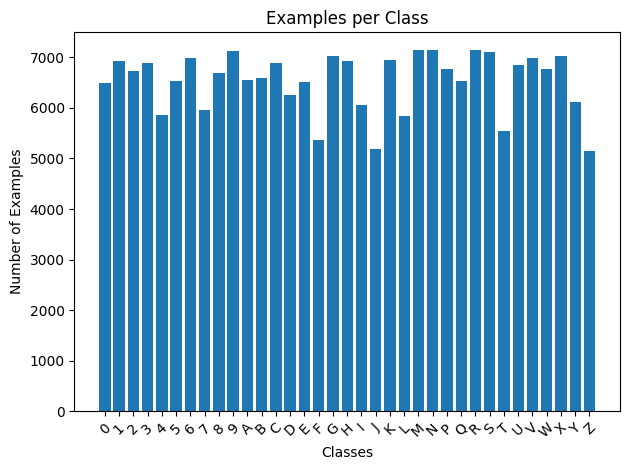


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Examples per class: [6490, 6930, 6730, 6890, 5870, 6540, 6990, 5960, 6700, 7120, 6560, 6590, 6890, 6250, 6510, 5360, 7020, 6920, 6050, 5180, 6940, 5850, 7140, 7140, 6780, 6530, 7140, 7100, 5540, 6850, 6990, 6780, 7030, 6110, 5150]
Total examples: 228620
Average examples per class: 6532.00


In [12]:
# Importing libraries
import os
from matplotlib import pyplot as plt

# Checking the training dataset

# Checking the number of examples to guarantee balanced training
base_path = "./data/augmented_data/" 
classes = [entry.name for entry in os.scandir(base_path)]
print(f"Number of classes: {len(classes)}")

# Count examples per class and create bar chart
examples_count = [len(list(os.scandir(f"{base_path}/{char}"))) for char in classes]
plt.bar(classes, examples_count)
plt.title("Examples per Class")
plt.xlabel("Classes")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nClasses: {classes}")
print(f"Examples per class: {examples_count}")
print(f"Total examples: {sum(examples_count)}")
print(f"Average examples per class: {sum(examples_count) / len(examples_count):.2f}")

not perfect, but acceptable (max ratio of 1.4 : 1)

#### Data augmentation

In [13]:
import os
import cv2
import albumentations as A
from concurrent.futures import ProcessPoolExecutor

# --- Configuration ---
BASE_PATH = "./data/cleaned/"
SOURCE_DIR = BASE_PATH
OUTPUT_DIR = './data/augmented_data'
NUM_AUGMENTATIONS_PER_IMAGE = 10 # How many new versions to create for each original

# These are good augmentations for character OCR. They are applied with some probability.
transform = A.Compose([
    A.Affine(
        translate_percent=0.05,
        scale=(0.95, 1.05),
        rotate=(-10, 10),
        p=0.8
    ),
    A.MotionBlur(blur_limit=5, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
])

def augment_and_save(image_filename):
    # Create output directory if it doesn't exist
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    filepath = os.path.join(SOURCE_DIR, image_filename)
    try:
        # Read the image using OpenCV
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Could not read {image_filename}, skipping.")
            return 0
        
        original_output_path = os.path.join(OUTPUT_DIR, image_filename)
        os.makedirs(os.path.dirname(original_output_path), exist_ok=True)
        cv2.imwrite(original_output_path, image)

        # Generate and save augmented images
        saved_count = 1
        base_filename = os.path.splitext(image_filename)[0]
        
        for i in range(NUM_AUGMENTATIONS_PER_IMAGE):
            augmented = transform(image=image)
            augmented_image = augmented['image']

            new_filename = f"{base_filename}_aug_{i}.png"
            output_path = os.path.join(OUTPUT_DIR, new_filename)
            
            # Create subdirectory if it doesn't exist
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            
            cv2.imwrite(output_path, augmented_image)
            saved_count += 1
        return saved_count
    except Exception as e:
        print(f"Error processing {image_filename}: {e}")
        return 0


In [ ]:

folders = [entry.name for entry in os.scandir(BASE_PATH)]

for folder_name in folders:
  print(folder_name)

  image_files = [f"{folder_name}/{f}" for f in os.listdir(SOURCE_DIR+folder_name) if f.endswith(('.png'))]

  # Use ProcessPoolExecutor to run augmentations on all available CPU cores
  with ProcessPoolExecutor() as executor:
      results = executor.map(augment_and_save, image_files)

  # total_saved = sum(results)
  # print(f"\nGenerated a total of {total_saved} augmented images for class")

#### Applying the same preprocessing to eval data

In [19]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# --- Configuration ---
SOURCE_DIR = './data/eval/'
OUTPUT_DIR = './data/processed_eval/'
NEW_SIZE = (40, 30)  # Must be the same size as your training images (width, height)

# --- 1. Function to process a single image ---
def process_image(relative_path):
    """
    Reads, resizes, and applies Otsu's thresholding to a single image.
    """
    try:
        # Construct full input and output paths
        full_input_path = os.path.join(SOURCE_DIR, relative_path)
        full_output_path = os.path.join(OUTPUT_DIR, relative_path)

        # Create the destination subdirectory if it doesn't exist
        os.makedirs(os.path.dirname(full_output_path), exist_ok=True)

        # Read the image in grayscale
        image = cv2.imread(full_input_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return 0  # Skip if image can't be read

        # STEP 1: Resize the image
        resized_image = cv2.resize(image, NEW_SIZE, interpolation=cv2.INTER_AREA)

        # STEP 2: Apply Otsu's Thresholding
        processed_image = cv2.threshold(resized_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Save the final processed image
        cv2.imwrite(full_output_path, processed_image)
        return 1  # Return 1 for success
    except Exception as e:
        print(f"Error processing {relative_path}: {e}")
        return 0

# --- 2. Main execution block ---
if __name__ == "__main__":
    # Find all image files to process
    all_image_paths = []
    for root, _, files in os.walk(SOURCE_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                relative_path = os.path.relpath(os.path.join(root, file), SOURCE_DIR)
                all_image_paths.append(relative_path)

    if not all_image_paths:
        print(f"No images found in {SOURCE_DIR}. Please check the path.")
    else:
        print(f"Found {len(all_image_paths)} evaluation images to process. Starting...")

        # Use ProcessPoolExecutor to run on all available CPU cores
        with ProcessPoolExecutor() as executor:
            results = list(tqdm(executor.map(process_image, all_image_paths), total=len(all_image_paths)))

        total_processed = sum(results)
        print(f"\n✅ Done! Successfully processed and saved {total_processed} images to {OUTPUT_DIR}")

Found 10650 evaluation images to process. Starting...


100%|██████████| 10650/10650 [00:04<00:00, 2338.85it/s]



✅ Done! Successfully processed and saved 10650 images to ./data/processed_eval/


#### Data formatting for training and eval

In [21]:
import tensorflow as tf

# --- Configuration ---
BATCH_SIZE = 32
IMG_HEIGHT = 30
IMG_WIDTH = 40
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

# --- Define paths ---
caminho_train = 'data/augmented_data'
caminho_eval = 'data/processed_eval'

# --- Load Training and Validation Data ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    caminho_train,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    caminho_eval,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# --- THE FIX: Get class_names BEFORE you modify the dataset ---
class_names = train_ds.class_names
print(f"✅ Found {len(class_names)} classes: {class_names}")
# -------------------------------------------------------------

# --- Normalize and Optimize ---
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("✅ Data preparation complete and optimized.")

Found 251471 files belonging to 35 classes.
Found 10650 files belonging to 35 classes.
✅ Found 35 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
✅ Data preparation complete and optimized.


### Model construction, training and eval

#### modular CNN function

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

def create_model(input_shape, num_classes, filters_per_layer=[32, 64], dense_units=128):
    """Creates a flexible CNN model."""
    
    model = Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    # Convolutional blocks
    for filters in filters_per_layer:
        model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Classifier head
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) # Dropout is a key regularizer
    model.add(Dense(num_classes, activation='softmax', dtype='float32')) # Output layer

    return model

#### Training

In [23]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

# --- Setup ---
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)
NUM_CLASSES = len(class_names) # Get number of classes from the loaded data

# --- Define Your Experiments ---
experiments = [
    {'id': 'lr_1e-3', 'learning_rate': 1e-3},
    {'id': 'lr_5e-4', 'learning_rate': 5e-4},
    {'id': 'lr_1e-4', 'learning_rate': 1e-4},
]

for config in experiments:
    print(f"\n--- Running Experiment: {config['id']} ---")

    model = create_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    log_dir = os.path.join("logs", config['id'])
    model_path = os.path.join("models", f"{config['id']}_best_model.keras")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    callbacks = [
        TensorBoard(log_dir=log_dir),
        ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_accuracy', mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    ]

    history = model.fit(
        train_ds,
        epochs=100, # Set high, EarlyStopping will handle it
        validation_data=val_ds,
        callbacks=callbacks
    )


--- Running Experiment: lr_1e-3 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       573,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,795 (2.28 MB)

 Trainable params: 597,347 (2.28 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
   1/7859 ━━━━━━━━━━━━━━━━━━━━ 14:17:32 7s/step - accuracy: 0.0000e+00 - loss: 4.8070

2025-07-31 04:14:15.750580: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22118400 exceeds 10% of free system memory.
2025-07-31 04:14:15.750839: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22118400 exceeds 10% of free system memory.


   2/7859 ━━━━━━━━━━━━━━━━━━━━ 21:38 165ms/step - accuracy: 0.0078 - loss: 4.6635    

2025-07-31 04:14:16.012570: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22118400 exceeds 10% of free system memory.
2025-07-31 04:14:16.023301: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22118400 exceeds 10% of free system memory.
2025-07-31 04:14:16.191650: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22118400 exceeds 10% of free system memory.


1296/7859 ━━━━━━━━━━━━━━━━━━━━ 12:49 117ms/step - accuracy: 0.7937 - loss: 0.7886

KeyboardInterrupt: 

### Evaluation

In [ ]:
import tensorflow as tf

# --- Evaluate the Best Model ---
# Find which model performed best by checking the logs or filenames.
# Let's assume the 'lr_5e-4' model was the best.
best_model_path = 'models/lr_5e-4_best_model.keras'

print(f"Loading best model from: {best_model_path}")
loaded_model = tf.keras.models.load_model(best_model_path)

# Evaluate the loaded model on your actual evaluation data
print("\nEvaluating on the processed evaluation dataset:")
loss, accuracy = loaded_model.evaluate(val_ds, verbose=2)

print(f"\nEvaluation Accuracy: {accuracy*100:.2f}%")

313/313 - 2s - 8ms/step - accuracy: 0.9860 - loss: 0.1554


### Post-training efficiency increase
Quantization, ...